## Time Series Pred: Milk production data
https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

** Dataset Information: **

Monthly milk production during Jan 62 - Dec 75

** Attribute Information: **

- Month 
- milk production (pounds per cow). Jan 62 - Dec 75

** Objective of this project **

predict the last 12 months milk production based on the data during the previous period

## Data

            Milk Production
Month                      
1962-01-01            589.0
1962-02-01            561.0
1962-03-01            640.0
1962-04-01            656.0
1962-05-01            727.0


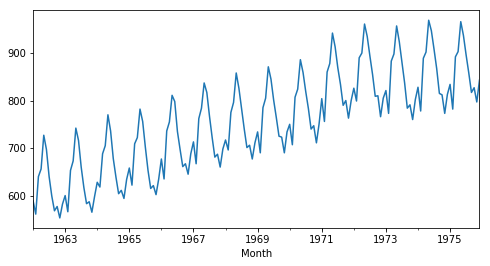

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data
series = pd.read_csv('monthly-milk-production.csv',index_col='Month',
                    parse_dates=True).astype('float64')
print(series.head())
series.plot(legend=False, figsize=(8,4))
plt.show()

#### Autocorrelation

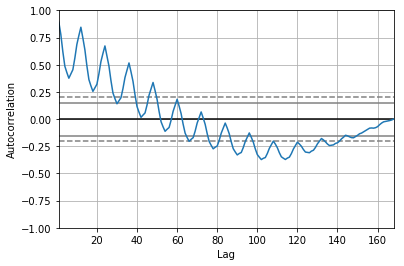

In [6]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

#### Augmented Dickey-Fuller test

In [9]:
from statsmodels.tsa.stattools import adfuller
X = series.values.ravel()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.303812
p-value: 0.627427
Critical Values:
	1%: -3.474
	5%: -2.880
	10%: -2.577


## Persistence Model (baseline)

In [15]:
X.shape

(168, 1)

In [17]:
X[-12:].shape

(12, 1)

In [19]:
X[:-12].shape

(156, 1)

     t-1  t+1
0    NaN  589
1  589.0  561
2  561.0  640
3  640.0  656
4  656.0  727

Test MSE: 2341.500


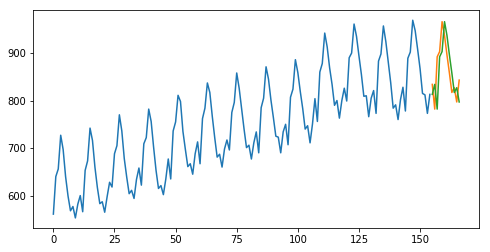

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

# load data
series = pd.read_csv('monthly-milk-production.csv',index_col='Month',
                    parse_dates=True)

# Data Preprocessing
#lagged dataset
values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t-1', 't+1']
print(df.head())

#train test set
X = df.values
#train_size = int(len(X) * 0.7)
#train, test = X[1:train_size], X[train_size:]
train, test = X[1:-12], X[-12:]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

# Define persistence model
def model_persistence(x):
    return x

# Make predictions & Evaluate model
y_pred = list()
for x in X_test:
    yhat = model_persistence(x)
    y_pred.append(yhat)
test_score = mean_squared_error(y_test, y_pred )
print('\nTest MSE: %.3f' % test_score)

# Visualize results
plt.figure(figsize=(8,4))
plt.plot(y_train)
plt.plot([None for i in y_train] + [x for x in y_test])
plt.plot([None for i in y_train] + [x for x in y_pred])
plt.show()

## Autoregressive Integrated Moving Average Model (ARIMA)

                             ARIMA Model Results                              
Dep. Variable:      D.Milk Production   No. Observations:                  167
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -846.911
Method:                       css-mle   S.D. of innovations             38.435
Date:                Sat, 03 Mar 2018   AIC                           1707.823
Time:                        20:36:05   BIC                           1729.649
Sample:                    02-01-1962   HQIC                          1716.682
                         - 12-01-1975                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.3304      2.556      0.521      0.603      -3.679       6.340
ar.L1.D.Milk Production     0.0022      0.077      0.029      0.977      -0.149       0.154


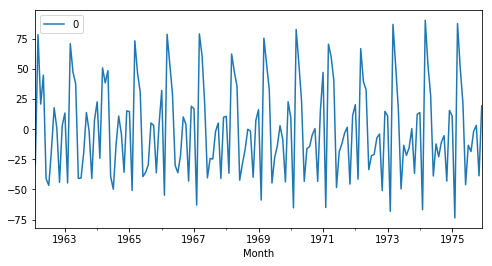

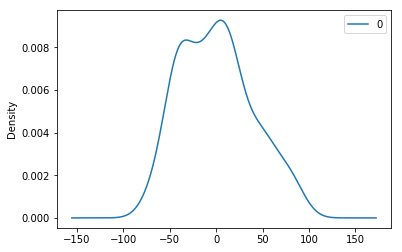

                0
count  167.000000
mean     0.310004
std     38.741140
min    -73.586711
25%    -35.818929
50%     -0.046459
75%     22.311214
max     90.327221


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

# load data
series = pd.read_csv('monthly-milk-production.csv',index_col='Month',
                    parse_dates=True).astype('float64')

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(8,4))
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Rolling Forecast ARIMA Model

predicted=823.093686, expected=834.000000
predicted=855.969583, expected=782.000000
predicted=803.340403, expected=892.000000
predicted=850.298351, expected=903.000000
predicted=941.838158, expected=966.000000
predicted=985.933998, expected=937.000000
predicted=909.746594, expected=896.000000
predicted=877.464176, expected=858.000000
predicted=819.019526, expected=817.000000
predicted=824.128828, expected=827.000000
predicted=836.160800, expected=797.000000
predicted=823.135817, expected=843.000000
Test MSE: 1809.589


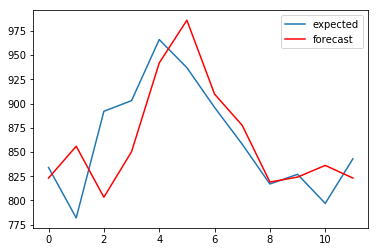

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline

# load data
series = pd.read_csv('monthly-milk-production.csv',index_col='Month',
                    parse_dates=True).astype('float64')
X = series.values
#size = int(len(X) * 0.7)
#train, test = X[0:size], X[size:len(X)]
train, test = X[:-12], X[-12:]
#X_train, y_train = train[:,0], train[:,1]
#X_test, y_test = test[:,0], test[:,1]

history = [x for x in train]
y_pred = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    y_pred.append(yhat)
    obs = test[t]
    history.append(obs)
    #if t % 10 == 0:
    print('predicted=%f, expected=%f' % (yhat, obs))   
error = mean_squared_error(test, y_pred)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test, label='expected')
plt.plot(y_pred, color='red', label='forecast')
plt.legend()
plt.show()

## Parameter Tuning

In [36]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train, test = X[:-12], X[-12:]
    #train_size = int(len(X) * 0.66)
    #train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    y_pred = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        y_pred.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, y_pred)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')
series = pd.read_csv('monthly-milk-production.csv',index_col='Month',
                    parse_dates=True).astype('float64')

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=15582.017
ARIMA(0, 0, 1) MSE=6723.608
ARIMA(0, 1, 0) MSE=2350.971
ARIMA(0, 1, 1) MSE=2373.200
ARIMA(0, 1, 2) MSE=2132.565
ARIMA(0, 2, 0) MSE=5286.540
ARIMA(0, 2, 1) MSE=2396.039
ARIMA(0, 2, 2) MSE=2420.411
ARIMA(1, 0, 0) MSE=2330.662
ARIMA(1, 0, 1) MSE=2371.702
ARIMA(1, 0, 2) MSE=2081.898
ARIMA(1, 1, 0) MSE=2384.578
ARIMA(1, 1, 1) MSE=2402.290
ARIMA(1, 1, 2) MSE=2118.860
ARIMA(1, 2, 0) MSE=2974.904
ARIMA(1, 2, 1) MSE=2902.833
ARIMA(2, 0, 0) MSE=2402.644
ARIMA(2, 0, 1) MSE=2424.833
ARIMA(2, 0, 2) MSE=2091.654
ARIMA(2, 1, 0) MSE=2243.509
ARIMA(2, 1, 1) MSE=2252.410
ARIMA(2, 1, 2) MSE=2306.299
ARIMA(2, 2, 0) MSE=2888.275
ARIMA(2, 2, 1) MSE=2770.766
ARIMA(4, 0, 0) MSE=2258.800
ARIMA(4, 0, 1) MSE=1641.569
ARIMA(4, 0, 2) MSE=1637.194
ARIMA(4, 1, 0) MSE=1795.969
ARIMA(4, 1, 1) MSE=2333.052
ARIMA(4, 1, 2) MSE=1501.770
ARIMA(4, 2, 0) MSE=2537.123
ARIMA(4, 2, 1) MSE=1830.771
ARIMA(6, 0, 0) MSE=1840.303
ARIMA(6, 0, 1) MSE=1779.112
ARIMA(6, 1, 0) MSE=1581.953
ARIMA(6, 1, 1) MSE=